In [85]:
#Realizando os primeiros imports e instalações necessários
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
from prophet import Prophet
import xgboost as xg

In [86]:
#Primeira análise exploratória do arquivo. O arquivo original se encontra dividido em várias abas por estado, teremos de modificar isto. Do jeito em
#que se encontra, apenas municípios do Acre são exibidos nas pesquisas
df_in = pd.read_excel('indicadoressegurancapublicamunic.xlsx')
df_in

,Cód_IBGE,Município,Sigla UF,Região,Mês/Ano,Vítimas
0,1200138,Bujari,AC,NORTE,2018-01-01,1
1,1200203,Cruzeiro Do Sul,AC,NORTE,2018-01-01,8
2,1200302,Feijó,AC,NORTE,2018-01-01,3
3,1200328,Jordão,AC,NORTE,2018-01-01,1
4,1200336,Mâncio Lima,AC,NORTE,2018-01-01,1
...,...,...,...,...,...,...
818,1200328,Jordão,AC,NORTE,2022-12-01,1
819,1200401,Rio Branco,AC,NORTE,2022-12-01,11
820,1200500,Sena Madureira,AC,NORTE,2022-12-01,2
821,1200450,Senador Guiomard,AC,NORTE,2022-12-01,5


In [87]:
#Carregando o arquivo Excel para começar o processo de união de todas as abas do Excel em uma única aba
caminho_arquivo = 'indicadoressegurancapublicamunic.xlsx'
excel_file = pd.ExcelFile(caminho_arquivo)

#Printando as abas (sheets)
nome_das_abas = excel_file.sheet_names
nome_das_abas

['AC',
 'AL',
 'AP',
 'AM',
 'BA',
 'CE',
 'DF',
 'ES',
 'GO',
 'MA',
 'MT',
 'MS',
 'MG',
 'PA',
 'PB',
 'PR',
 'PE',
 'PI',
 'RJ',
 'RN',
 'RS',
 'RO',
 'RR',
 'SC',
 'SP',
 'SE',
 'TO']

In [88]:
#Criando uma lista e um loop para armazenar os DataFrames de cada estado
lista_df = []

for aba in nome_das_abas:
    df_estado = pd.read_excel(excel_file, sheet_name=aba)

    #Adiciona à lista
    lista_df.append(df_estado)

#Unindo todos os DataFramaes da lista em um único
df_completo = pd.concat(lista_df, ignore_index=True)

#Visualizando informações sobre os dados concatenados, bem como os próprios dados finais pós-junção
print(df_completo.info())
df_completo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294706 entries, 0 to 294705
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Cód_IBGE   294706 non-null  int64         
 1   Município  294706 non-null  object        
 2   Sigla UF   294706 non-null  object        
 3   Região     294706 non-null  object        
 4   Mês/Ano    294706 non-null  datetime64[ns]
 5   Vítimas    294706 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.5+ MB
None


,Cód_IBGE,Município,Sigla UF,Região,Mês/Ano,Vítimas
0,1200138,Bujari,AC,NORTE,2018-01-01,1
1,1200203,Cruzeiro Do Sul,AC,NORTE,2018-01-01,8
2,1200302,Feijó,AC,NORTE,2018-01-01,3
3,1200328,Jordão,AC,NORTE,2018-01-01,1
4,1200336,Mâncio Lima,AC,NORTE,2018-01-01,1
...,...,...,...,...,...,...
294701,1716653,Pequizeiro,TO,NORTE,2022-12-01,1
294702,1717206,Piraquê,TO,NORTE,2022-12-01,1
294703,1718303,Praia Norte,TO,NORTE,2022-12-01,2
294704,1718402,Presidente Kennedy,TO,NORTE,2022-12-01,2


In [89]:
#Ainda que o Non-Null count tenha informado que não existem dados nulos, confirmando a informação
df_completo.isnull().sum()

Cód_IBGE     0
Município    0
Sigla UF     0
Região       0
Mês/Ano      0
Vítimas      0
dtype: int64

In [31]:
#Exportando o arquivo final para CSV para realizar análises explorativas no Power BI
df_completo.to_csv('dados_seguranca_final.csv',
                   sep=',',
                   index=False,
                   encoding='utf-8-sig')

print('Arquivo criado com sucesso!')

Arquivo criado com sucesso!


Análises explorativas feitas no Power BI com o arquivo criado. De agora em diante neste arquivo, utilizarei Python para fazer análises preditivas, com o uso de algoritmos para tentar prever o futuro (24 meses após o término dos dados) baseado nos dados que possuímos. Primeiramente, por se tratar de um algoritmo "simples" e que pode servir para a proposta, decidi começar utilizando o algoritmo de regressão linear para tentar prever os homicídios nos próximos dois anos após o término dos dados.

In [90]:
#Agrupando os dados por mês para termos uma série temporal
df_temporal = df_completo.groupby('Mês/Ano')['Vítimas'].sum().reset_index()

#Transformando as datas em um número sequencial ordinal, visto que o algoritmo não sabe ler datas
df_temporal['Mes_Sequencial'] = np.arange(len(df_temporal))

#Criando as variáveis dependentes e independentes
x = df_temporal[['Mes_Sequencial']]
y = df_temporal[['Vítimas']]

In [91]:
#Criando e treinando o modelo
modelo = LinearRegression()
modelo.fit(x,y)

#Fazendo a previsão para os dados históricos
df_temporal['Previsao_Linear'] = modelo.predict(x)

In [92]:
#Tentando prever os próximos 24 meses em sequência
ultimo_mes_seq = df_temporal['Mes_Sequencial'].max()
meses_futuros_seq = np.arange(ultimo_mes_seq + 1, ultimo_mes_seq + 25).reshape(-1, 1)

#Transformando o array em DataFrames para evitar erros de inconsistência
x_futuro = pd.DataFrame(meses_futuros_seq, columns=['Mes_Sequencial'])

#Calculando a previsão para esses meses futuros
previsao_futura = modelo.predict(x_futuro)

#Estabelecendo o R² e a MAE para medir a precisão do modelo
r2 = r2_score(y, df_temporal['Previsao_Linear'])
mae = mean_absolute_error(y, df_temporal['Previsao_Linear'])

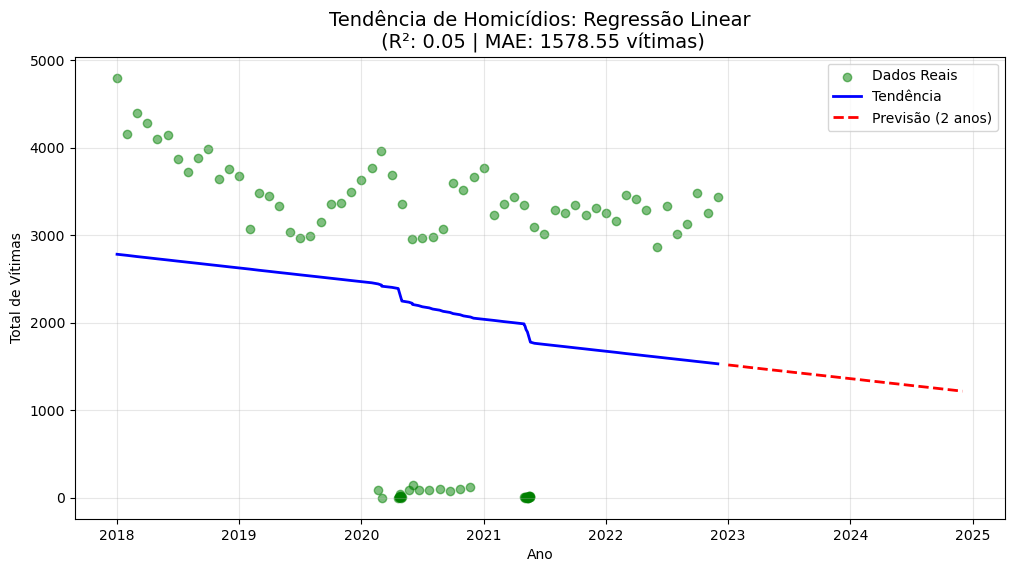

In [93]:
#Criando um gráfico para exibir os resultados obtidos pelo algoritmo
plt.figure(figsize=(12,6))

#Passando os dados
plt.scatter(df_temporal['Mês/Ano'], y, color = 'green', label = 'Dados Reais', alpha = 0.5)

#Criando uma linha de regressão (histórico)
plt.plot(df_temporal['Mês/Ano'], df_temporal['Previsao_Linear'], color ='blue', linewidth = 2, label = 'Tendência')

#Criando a linha de regressão do futuro (previsão)
plt.plot(datas_futuras, previsao_futura, color = 'red', linestyle = '--', linewidth = 2, label = 'Previsão (2 anos)')

#Detalhes do gráfico
plt.title(f'Tendência de Homicídios: Regressão Linear\n (R²: {r2:.2f} | MAE: {mae:.2f} vítimas)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Total de Vítimas')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

Meu plano inicial consistia em utilizar somente o algoritmo de regressão linar para tentar prever o número de vítimas que ocorreriam nos próximos dois anos, porém, como pode ser percebido pelo baixíssimo R² (0 implica que o modelo não explica a variação nos dados, ou seja, como o valor obtido foi de 0.05, o gráfico obtido não corresponde em quase nada com a realidade) e alto MAE, o algoritmo não foi capaz nem de criar uma linha concisa dos dados presentes e nem de prever seguramente o futuro. Assim sendo, pedi para a IA sugestões de quais algoritmos poderia utilizar neste caso para obter uma taxa de confiabilidade mais segura, ao que a IA (Gemini) me sugeriu utilizar o Prophet, cujo algoritmo será aplicado em seguida.
Ainda assim, o gráfico anterior e o algoritmo de regressão linear foram úteis para demonstrar uma tendência: Uma tendência decrescente nos números (indicando diminuição da violência com o passar do tempo), ainda que muito inexata.

In [94]:
#Começando a trabalhar com o algoritmo Prophet, que exige duas colunas: 'ds' (datestamp) e 'y' (valor numérico)
df_prophet = df_temporal[['Mês/Ano', 'Vítimas']].copy()
df_prophet.columns = ['ds', 'y']

#Criando e treinando o modelo. Ativei a sazonalidade anual para que o modelo entenda os meses do ano
modelo_prophet = Prophet(yearly_seasonality = True, interval_width=0.95)
modelo_prophet.fit(df_prophet)

17:27:14 - cmdstanpy - INFO - Chain [1] start processing
17:27:14 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
#Criando o DataFrame do futuro (2 anos)
futuro_prophet = modelo_prophet.make_future_dataframe(periods=24, freq='MS')

#Realizando previsões
previsao_prophet = modelo_prophet.predict(futuro_prophet)

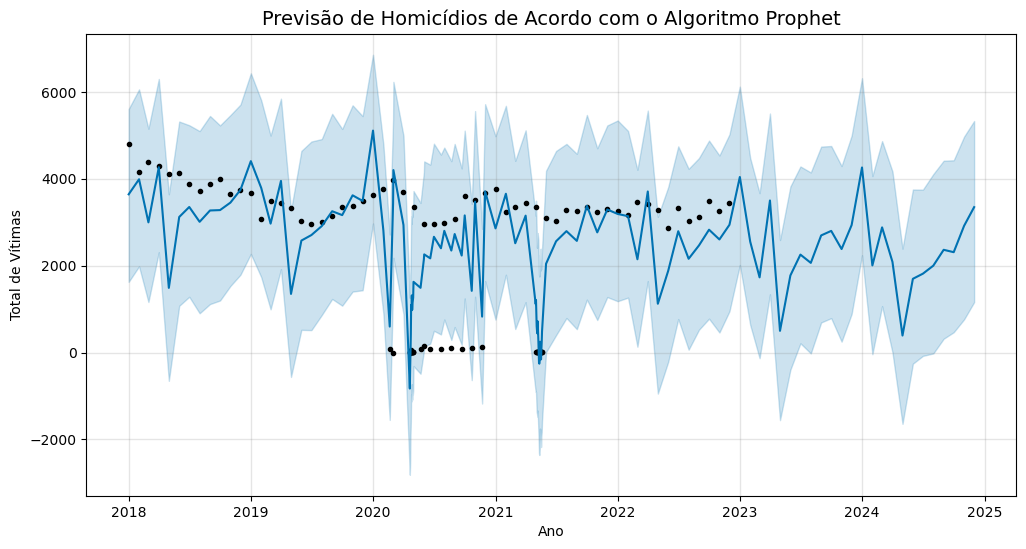

In [96]:
#Criação de gráficos para visualização de resultados
plt.figure(figsize=(12,6))
modelo_prophet.plot(previsao_prophet, ax=plt.gca())

plt.title('Previsão de Homicídios de Acordo com o Algoritmo Prophet', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Total de Vítimas')
plt.show()

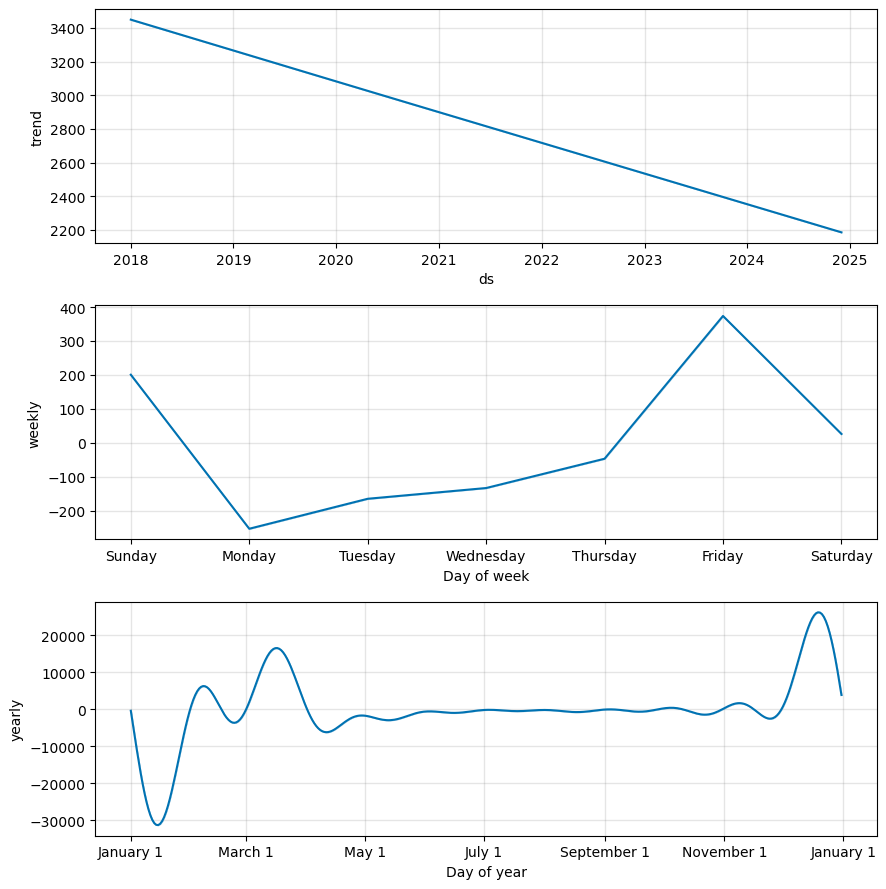

In [97]:
#Fazendo previsões dos componentes individuais da tabela inicial, como dias da semana e meses, a título de curiosidade
modelo_prophet.plot_components(previsao_prophet)
plt.show()

In [98]:
#Ainda não estou convencido sobre a eficácia do modelo, portanto calcularei o R², MAE e demais métricas para verificar sua confiabilidade. O DataFrame
#'previsao' contém uma coluna 'yhat' que é a estimativa do modelo
y_real = df_prophet['y']
y_predito = previsao_prophet.iloc[:len(df_prophet)]['yhat']

r2 = r2_score(y_real, y_predito)

#Calculando o MAE e RMSE
mae = mean_absolute_error(y_real, y_predito)
rmse = root_mean_squared_error(y_real, y_predito)

#E por último, o erro percentual, outra métrica interessante para verificar a confiabilidade das previsões
erro_percentual = (mae / df_prophet['y'].mean()) * 100

#Demonstrando os resultados
print(f"O R² do modelo Prophet é {r2:.4f} , a MAE é {mae:.2f} vítimas, o RMSE é {rmse:.2f} vítimas, e o erro percentual é {erro_percentual:.2f}%")

O R² do modelo Prophet é 0.6245 , a MAE é 757.28 vítimas, o RMSE é 1040.88 vítimas, e o erro percentual é 35.12%


Apesar deste modelo ser bem mais acurado do que o modelo de regressão linear, ainda assim ele não é muito confiável em seu estado natural. Um R² de 0.6245 e erro percentual de 35% indicam uma confiabilidade média, mas ainda aquém do que eu particularmente desejava. Tive de conversar com a IA novamente e pedi sugestões de outros modelos de algoritmos ou mesmo mudanças nos algoritmos já testados para fazê-los se tornarem mais eficazes tanto nas suas medições passadas quanto nas predições futuras, e a IA (Gemini) sugeriu tanto tratar alguns dados como também tentar outros modelos, como o XGBoost. Segue abaixo o mesmo código feito anteriormente, porém com alterações feitas para remover possíveis outliers (dados faltantes, como por exemplo cidades aonde ocorreram 0 crimes no período de 4 anos, o que é muito improvável para não dizer impossível).

17:27:21 - cmdstanpy - INFO - Chain [1] start processing
17:27:22 - cmdstanpy - INFO - Chain [1] done processing


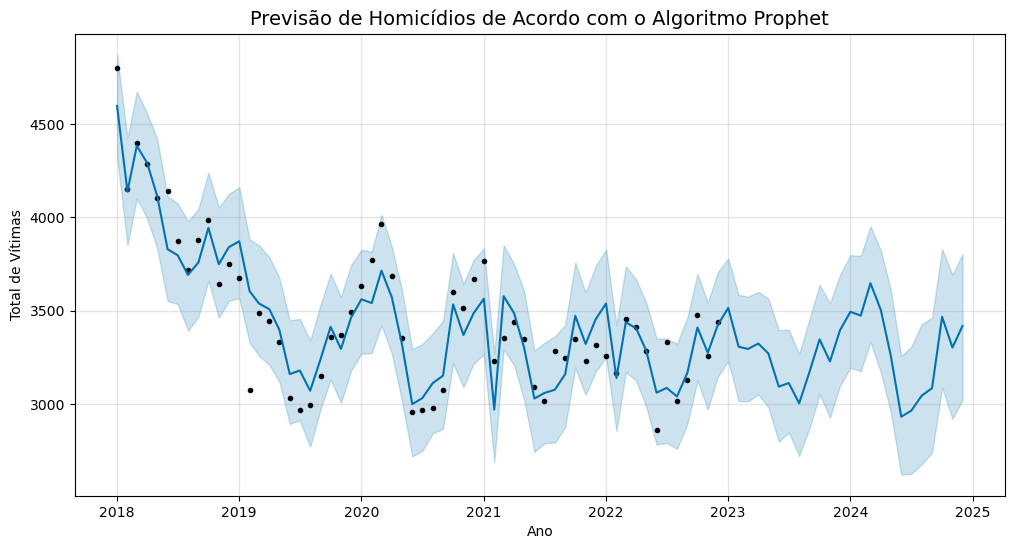

In [99]:
#Aplicando um filtro para considerar apenas cidados com número de vítimas mensal superior a 150. Cheguei ao número 150 depois de muitos testes, números
#abaixo de 100 ainda fazem o resultado final apresentar muita variância
df_temporal_filtrado = df_temporal[df_temporal['Vítimas'] > 150].copy()

df_prophet = df_temporal_filtrado[['Mês/Ano', 'Vítimas']].copy()
df_prophet.columns = ['ds', 'y']

modelo_prophet = Prophet(yearly_seasonality=True, interval_width=0.95)
modelo_prophet.fit(df_prophet)

futuro_prophet = modelo_prophet.make_future_dataframe(periods=24, freq='MS')

previsao_prophet = modelo_prophet.predict(futuro_prophet)

plt.figure(figsize=(12,6))
modelo_prophet.plot(previsao_prophet, ax=plt.gca())

plt.title('Previsão de Homicídios de Acordo com o Algoritmo Prophet', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Total de Vítimas')
plt.show()

In [114]:
#Agora, calculando a eficácia deste novo modelo
y_real = df_prophet['y']
y_predito = previsao_prophet.iloc[:len(df_prophet)]['yhat']

r2 = r2_score(y_real, y_predito)

#Calculando o MAE e RMSE
mae = mean_absolute_error(y_real, y_predito)
rmse = root_mean_squared_error(y_real, y_predito)

#E por último, o erro percentual, outra métrica interessante para verificar a confiabilidade das previsões
erro_percentual = (mae / df_prophet['y'].mean()) * 100

#Demonstrando os resultados
print(f"O R² do modelo Prophet é {r2:.4f} , a MAE é {mae:.2f} vítimas, o RMSE é {rmse:.2f} vítimas, e o erro percentual é {erro_percentual:.2f}%")

O R² do modelo Prophet é 0.8657 , a MAE é 107.96 vítimas, o RMSE é 145.29 vítimas, e o erro percentual é 3.11%


Os novos resultados obtidos foram excelentes. Como a IA me sugeriu utilizar outro modelo para comparar resultados, ainda que este resultado já tenha sido bom o suficiente, farei novos testes utilizando o algoritmo XGBoost para ver se ele se sai ainda melhor.

In [125]:
#Começando pelo mesmo exercício do algoritmo passado: Capei o número de vítimas a no mínimo 151 para evitar outliers extremos.
df_temporal = df_temporal[df_temporal['Vítimas'] > 150]

#Agora, criando os recursos de atraso (lags)
df_ml = df_temporal[['Mês/Ano', 'Vítimas']].copy()
df_ml['Mes'] = df_ml['Mês/Ano'].dt.month
df_ml['Ano'] = df_ml['Mês/Ano'].dt.year

#Criando "memória" para o modelo: Vítimas de 1,2 e 12 meses atrás
df_ml['lag_1'] = df_ml['Vítimas'].shift(1)
df_ml['lag_2'] = df_ml['Vítimas'].shift(2)
df_ml['lag_12'] = df_ml['Vítimas'].shift(12)

#Removendo as linhas com valores nulos que os "shifts" criaram
df_ml.dropna(inplace=True)

In [126]:
#Dividindo entre treino (passado) e teste (dados mais recentes). Treinarei com tudo até 2021 e testarei com 2022
train = df_ml[df_ml['Ano'] < 2022]
test = df_ml[df_ml['Ano'] == 2022]

x_train = train[['Mes', 'Ano', 'lag_1', 'lag_2', 'lag_12']]
y_train = train['Vítimas']
x_test = test [['Mes', 'Ano', 'lag_1', 'lag_2', 'lag_12']]
y_test = test['Vítimas']

In [127]:
#Criando e treinando o modelo. Inseri uma série de limitantes para que o modelo não se aprofunde muito nas variações sazonais inexplicáveis
#apresentadas nos dados
modelo_xg = xg.XGBRegressor(n_estimators=70, learning_rate = 0.05, max_depth=10, reg_alpha = 10, reg_lambda = 20)
modelo_xg.fit(x_train, y_train)

#Fazendo previsões para o período de teste
previsoes_xg = modelo_xg.predict(x_test)

#Verificando a confiabilidade do modelo
mae_xg = mean_absolute_error(y_test, previsoes_xg)
print(f"Novo MAE com o XGBoost: {mae_xg:.2f}")

Novo MAE com o XGBoost: 134.77


In [128]:
#Agora, mensurando também o R² do modelo. Previsão para o treino
y_pred_train = modelo_xg.predict(x_train)

#Previsão para o teste
y_pred_test = modelo_xg.predict(x_test)

#Calculando o R²
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"--- R² do XGBoost ---")
print(f"Treino: {r2_train:.4f}")
print(f"Teste: {r2_test:.4f}")

--- R² do XGBoost ---
Treino: 0.7441
Teste: 0.2829


Conversei com a IA sobre a confiabilidade deste modelo, que parece ser preocupante devido ao R² muito baixo principalmente na fase de testes, porém segundo palavras dela mesma:
"1. O MAE fala a língua do negócio
O MAE (Erro Médio Absoluto) é uma métrica na mesma unidade dos seus dados. Se você está contando corpos/vítimas, o seu MAE diz: "Em média, eu erro por 134 pessoas". Para um gestor de segurança, isso é palpável. Se a média mensal é de 3.400 vítimas, um erro de 134 representa apenas ~4% de erro. Veredito: O modelo é altamente confiável para planejamento, pois o erro é pequeno em relação ao volume total.
2. O R² é sensível à volatilidade
O R² mede o quanto da variância (as subidas e descidas) o modelo explica. Se os seus dados criminais oscilam de forma muito errática (um mês sobe 500, no outro cai 600), o R² vai exigir que o modelo acompanhe cada "ziguezague" perfeitamente para dar uma nota alta. Como o seu modelo está sendo mais "conservador" (seguindo a tendência sem tentar adivinhar cada susto do gráfico), o R² te penaliza. Veredito: Um R² baixo aqui não significa que o modelo é ruim, mas sim que os dados têm muito ruído imprevisível que nenhum cálculo matemático conseguiria prever 100%."

Logo, decidi seguir continuando o treinamento.

In [129]:
#Criando uma lista para guardar previsões futuras
previsoes_futuras = []
ultimos_dados = test.iloc[-1:].copy()

#Gerando datas para os próximos 24 meses
datas_projeto = pd.date_range(start='2023-01-01', periods=24, freq='MS')

#Preparando os inputs baseados na última linha conhecida/prevista
for data in datas_projeto:
    novo_input = pd.DataFrame({
        'Mes': [data.month],
        'Ano': [data.year],
        'lag_1': [ultimos_dados['Vítimas'].values[0]],
        'lag_2': [ultimos_dados['lag_1'].values[0]],
        'lag_12': [ultimos_dados['Vítimas'].values[0]]
    })

    #O XGBoost faz previsão para este mês específico
    pred = modelo_xg.predict(novo_input)[0]
    previsoes_futuras.append(pred)

    #Atualizando os 'ultimos_dados' para a próxima rodada do loop
    ultimos_dados = novo_input.copy()
    ultimos_dados['Vítimas'] = [pred]

#Criando o DataFrame com os resultados futuros
df_futuro_xg = pd.DataFrame({'Data': datas_projeto, 'Previsao': previsoes_futuras})

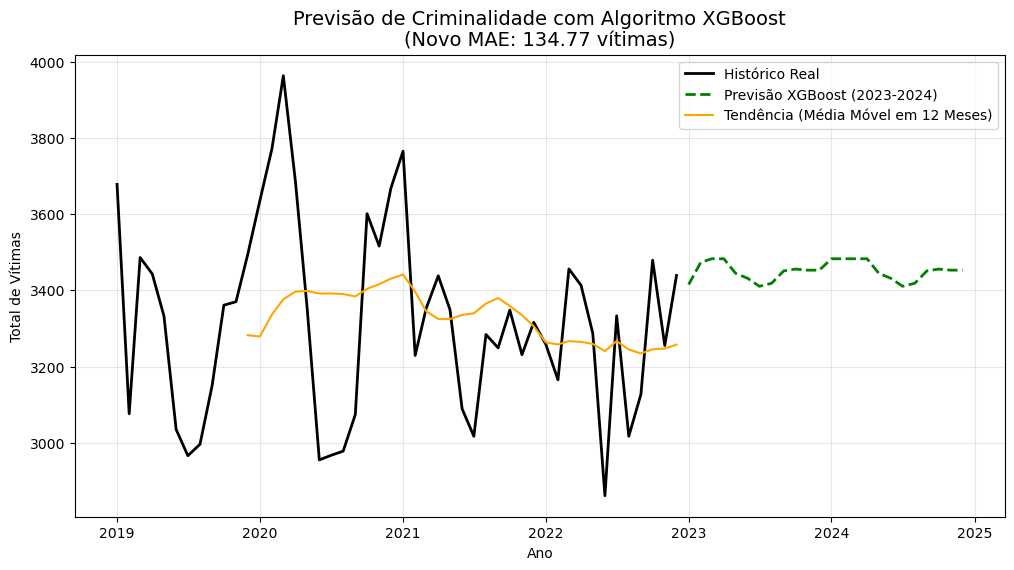

In [130]:
#Criando o gráfico com a demonstração dos resultados
plt.figure(figsize=(12,6))

#Inserindo os dados
plt.plot(df_ml['Mês/Ano'], df_ml['Vítimas'], color='black', label ='Histórico Real', linewidth=2)

#Previsões XGBoost para o futuro
plt.plot(df_futuro_xg['Data'], df_futuro_xg['Previsao'], color='green', linestyle = '--', label = 'Previsão XGBoost (2023-2024)', linewidth=2)

#Criando uma média movel de 12 meses para o histórico
df_ml['Media_Movel'] = df_ml['Vítimas'].rolling(window=12).mean()
plt.plot(df_ml['Mês/Ano'], df_ml['Media_Movel'], color = 'orange', label = 'Tendência (Média Móvel em 12 Meses)')

#Demonstrando o gráfico de fato
plt.title(f'Previsão de Criminalidade com Algoritmo XGBoost\n(Novo MAE: {mae_xg:.2f} vítimas)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Total de Vítimas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Para finalizar, o modelo criado, devido aos tratamentos dados como remoção de outliers, suavização das curvas do gráficos, menor profundidade de treinamento, etc, se focou mais em torno das médias do que dos valores absolutos dos dados coletados, assim o modelo gerado é consideravelmente pouco variante, porém erra pouco devido ao fato de sempre permanecer próximos das médias. Um modelo mais "fiel" à realidade poderia acertar mais no que diz respeito à existência de picos, porém erraria muito mais frequentemente do que este modelo, pois justamente os picos o distanciariam das médias, que é a medida mais acertiva e "conservadora" do que tange à confiabilidade de um gráfico. À título de curiosidade, deixo abaixo o gráfico criado sem os tratamentos, com maior variação de previsões e mais distante das médias. Como pode ser visto, o MAE aumenta sem os tratamentos, e o R² é bem menor neste modelo.

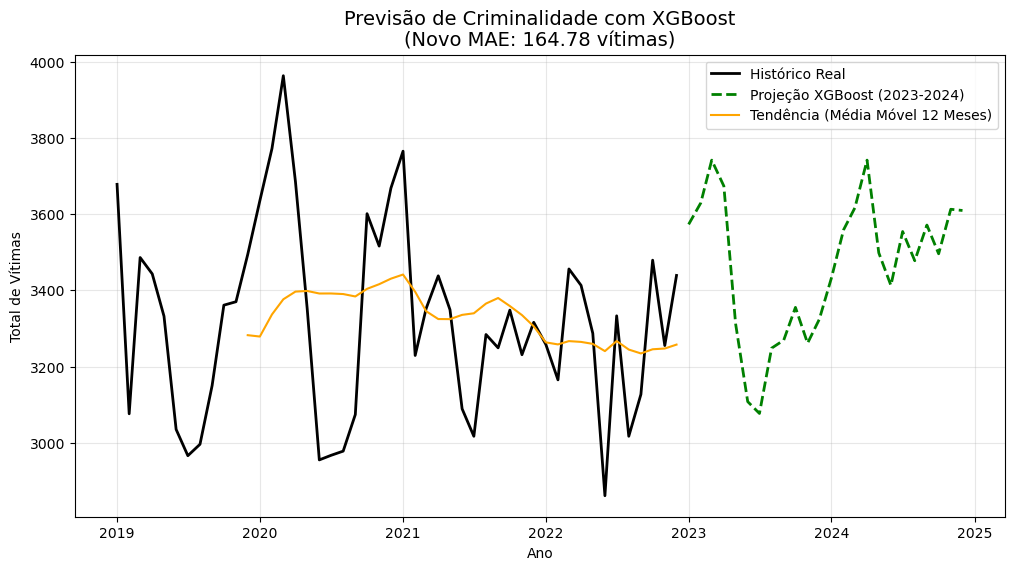

In [131]:
df_temporal = df_temporal[df_temporal['Vítimas'] > 150] 

df_ml = df_temporal[['Mês/Ano', 'Vítimas']].copy()
df_ml['Mes'] = df_ml['Mês/Ano'].dt.month
df_ml['Ano'] = df_ml['Mês/Ano'].dt.year

df_ml['lag_1'] = df_ml['Vítimas'].shift(1)
df_ml['lag_2'] = df_ml['Vítimas'].shift(2)
df_ml['lag_12'] = df_ml['Vítimas'].shift(12) 

df_ml.dropna(inplace=True)

train = df_ml[df_ml['Ano'] < 2022]
test = df_ml[df_ml['Ano'] == 2022]

X_train = train[['Mes', 'Ano', 'lag_1', 'lag_2', 'lag_12']]
y_train = train['Vítimas']
X_test = test[['Mes', 'Ano', 'lag_1', 'lag_2', 'lag_12']]
y_test = test['Vítimas']

modelo_xg = xg.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
modelo_xg.fit(X_train, y_train)

previsoes_xg = modelo_xg.predict(X_test)

mae_xg = mean_absolute_error(y_test, previsoes_xg)

previsoes_futuras = []
ultimos_dados = test.iloc[-1:].copy()

datas_projeto = pd.date_range(start='2023-01-01', periods=24, freq='MS')

for data in datas_projeto:
    novo_input = pd.DataFrame({
        'Mes': [data.month],
        'Ano': [data.year],
        'lag_1': [ultimos_dados['Vítimas'].values[0]], 
        'lag_2': [ultimos_dados['lag_1'].values[0]],
        'lag_12': [ultimos_dados['Vítimas'].values[0]] 
    })
    
    pred = modelo_xg.predict(novo_input)[0]
    previsoes_futuras.append(pred)
    
    ultimos_dados = novo_input.copy()
    ultimos_dados['Vítimas'] = [pred] 

df_futuro_xg = pd.DataFrame({'Data': datas_projeto, 'Previsao': previsoes_futuras})

plt.figure(figsize=(12, 6))

plt.plot(df_ml['Mês/Ano'], df_ml['Vítimas'], color='black', label='Histórico Real', linewidth=2)

plt.plot(df_futuro_xg['Data'], df_futuro_xg['Previsao'], color='green', linestyle='--', label='Projeção XGBoost (2023-2024)', linewidth=2)

df_ml['Media_Movel'] = df_ml['Vítimas'].rolling(window=12).mean()
plt.plot(df_ml['Mês/Ano'], df_ml['Media_Movel'], color='orange', label='Tendência (Média Móvel 12 Meses)')

plt.title(f'Previsão de Criminalidade com XGBoost\n(Novo MAE: {mae_xg:.2f} vítimas)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Total de Vítimas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Em conclusão, para este caso o algoritmo de regressão linear foi o menos confiável de todos os algoritmos testados, tendo servido apenas para demonstrar a tendência geral dos dados (ainda que não tenha feito o fatiamento dos dados nele, este ainda seria o pior dos algoritmos por não lidar muito bem com variações temporais acentuadas, o que é presente nestes dados). O algoritmo XGBoost ficou em segundo lugar, após terem sido feitos fatiamento e tratamento nos dados para exclusão de dados faltantes o algoritmo demonstrou resultados muito confiáveis e que poderiam muito bem ser utilizados para fazer previsões, pois já apresentam uma alta confiabilidade, porém o campeão foi o algoritmo Prophet, que atingiu surpreendentes valores de R² = 0.8657 , MAE de 107.96 vítimas, RMSE de 145.29 vítimas e erro percentual de apenas 3.11%, superando os 4% de margem de erro do XGBoost. Tanto o Prophet quanto o XGBoost podem ser utilizados para este caso, mas o Prophet se saiu ligeiramente melhor. Vale considerar que haviam muitos dados faltantes (cerca de 459 municípios não tinham dados sobre violência, como indicado no arquivo em formato pbix), o que configurou uma necessidade de tratamento e "correção" dos dados a fim de melhorar a confiabilidade final das previsões. Além das previsões feitas, podemos concluir que: Os dados utilizados não possuem intervalos de confiança estáveis, sendo estes portadores de grande sazonalidade e "eventos de baixa explicação", o que resulta em intervalos de confiança mais largos e que exigem modelos que lidem melhor com não-linearidade, como os utilizados XGBoost e o Prophet. Para finalizar, a previsão em números, e não apenas gráficos, utilizando o algoritmo Prophet.

In [133]:
#Isolando as previsões futuras (após a última data real)
ultima_data_real = df_temporal_filtrado['Mês/Ano'].max()
tab_final = previsao_prophet[previsao_prophet['ds'] > ultima_data_real][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy().round(2)

#Criando uma linha de total de vítimas e calculando as somas primeiro
soma_yhat = tab_final['yhat'].sum()
soma_lower = tab_final['yhat_lower'].sum()
soma_upper = tab_final['yhat_upper'].sum()

#Criando um DataFrame para a linha de total
linha_total = pd.DataFrame({
    'ds': ['Total de Vítimas em 2 Anos'], 
    'yhat': [soma_yhat], 
    'yhat_lower': [soma_lower], 
    'yhat_upper': [soma_upper]
})

#Formatando a data para string para permitir a palavra "Total" na mesma coluna
tab_final['ds'] = tab_final['ds'].dt.strftime('%m/%Y')

#Concatenando a tabela com o total
tabela_com_total = pd.concat([tab_final, linha_total], ignore_index=True)

#Renomeando as colunas para a apresentação final
tabela_com_total.columns = ['Período', 'Vítimas Previstas', 'Mínimo (95%)', 'Máximo (95%)']

print(tabela_com_total)

                       Período  Vítimas Previstas  Mínimo (95%)  Máximo (95%)
0                      01/2023            3515.31       3230.91       3778.85
1                      02/2023            3307.51       3016.17       3585.31
2                      03/2023            3295.25       3014.29       3575.61
3                      04/2023            3324.31       3051.74       3601.40
4                      05/2023            3270.95       2983.07       3565.16
5                      06/2023            3093.49       2798.59       3395.57
6                      07/2023            3112.74       2847.28       3399.40
7                      08/2023            3003.98       2723.04       3268.42
8                      09/2023            3173.39       2871.71       3456.00
9                      10/2023            3346.66       3051.39       3639.67
10                     11/2023            3228.45       2927.55       3539.83
11                     12/2023            3395.53       3098.34 